In [5]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
# 可以把Tensor转成Image，方便可视化
show = ToPILImage()

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # 归一化
    transforms.Normalize(std=(0.5, 0.5, 0.5), mean=(0.5, 0.5, 0.5))
])

In [8]:
trainset = tv.datasets.CIFAR10(
    root = 'F:/[Base] Code/DataSets',
    train = True,
    download = False,
    transform = transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = 4,
    shuffle = True,
    num_workers = 2
)

testset = tv.datasets.CIFAR10(
    'F:/[Base] Code/DataSets',
    train = False,
    download = False,
    transform = transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size = 4,
    shuffle = False,
    num_workers = 2
)

In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [17]:
(data, label) = trainset[100]
classes[label]

'ship'

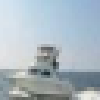

In [18]:
# (data + 1) / 2还原归一化的数据
show((data + 1) / 2).resize((100, 100))

        car        deer         cat       truck


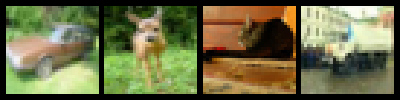

In [20]:
# DataLoader提供了一个可迭代对象，可将dateset返回的每一条数据样本拼接成一个batch
dataiter = iter(trainloader)
images, labels = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images + 1) / 2)).resize((400, 100))

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        super(Net, self).__init__()
        # 输入3通道，输出通道数6，卷积核size = 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 仿射层/全连接层, y = Wx + b
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # 卷积 → 激活 → 池化
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # reshape, -1表示自适应
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
# 定义损失函数和优化器
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [45]:
from torch.autograd import Variable
# train
for epoch in range(2):
    # ! init
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 输入数据
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data
        
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' \
                 %(epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('fin.')

[1,  2000] loss: 1.565
[1,  4000] loss: 1.524
[1,  6000] loss: 1.460
[1,  8000] loss: 1.437
[1, 10000] loss: 1.413
[1, 12000] loss: 1.361
[2,  2000] loss: 1.323
[2,  4000] loss: 1.293
[2,  6000] loss: 1.261
[2,  8000] loss: 1.271
[2, 10000] loss: 1.262
[2, 12000] loss: 1.243
fin.


In [46]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images)) # 输出为label，十类中的一个
    _,predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('10000张测试集中的准确率为：%d %%' % (100 * correct / total))

10000张测试集中的准确率为：55 %
